### 3.8.1 Views of another tensor's storage

In [1]:
import torch

In [2]:
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
second_point = points[1]
second_point.storage_offset()

2

In [3]:
second_point.size()

torch.Size([2])

In [4]:
second_point.shape

torch.Size([2])

- The stride is a tuple indicating the number of elements in the storage that have to be skipped when the index in increased by 1 in each dimension.

In [5]:
points.stride()

(2, 1)

- Accessing an element `i, j` in a 2D tensor results in accessing the `storage_offset + stride[0] * i + stride[1] * j` element in the storage.
- The offset will usually be zero; if this tensor is a view of a storage created to hold a larger tensor, the offset might be a positive value.
    - tensorがviewになっている設計から、C++のstring viewの設計を思い出した。
- This indirection between `Tensor` and `Storage` makes some operations inexpensive, like transposing a tensor or extracting a subtensor, because they do not lead to memory reallocations.

In [6]:
second_point = points[1]
second_point.size()

torch.Size([2])

In [7]:
second_point.storage_offset()

2

In [8]:
second_point.stride()

(1,)

- This also means **changing the subtensor will have a side effect on the original tensor**:(大事)

In [9]:
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
second_point = points[1]
second_point[0] = 10.0
points

tensor([[ 4.,  1.],
        [10.,  3.],
        [ 2.,  1.]])

- **This might not always be desirable**, so we can eventually clone the subtensor into a new tensor.

In [10]:
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
second_point = points[1].clone()
second_point[0] = 10.0
points

tensor([[4., 1.],
        [5., 3.],
        [2., 1.]])

### 3.8.2 Transposing without copying

- `t` function, a shorthand alternative to `transpose` for two-dimensional tensors:

In [11]:
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
points

tensor([[4., 1.],
        [5., 3.],
        [2., 1.]])

In [12]:
points_t = points.t()
points_t

tensor([[4., 5., 2.],
        [1., 3., 1.]])

In [13]:
id(points.storage()) == id(points_t.storage())

True

In [14]:
points.stride()

(2, 1)

In [15]:
points_t.stride()

(1, 2)

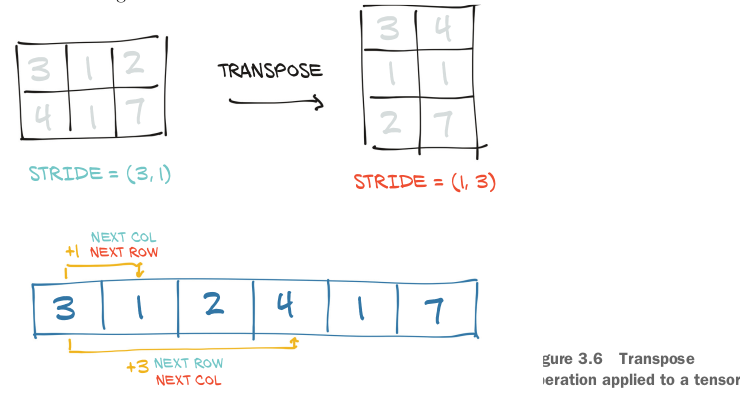

In [16]:
from PIL import Image
Image.open('img/transpose-on-tensor-2020-12-13-17-45-31.png')

### 3.8.3 Transposing in higher dimensions

- Transpose a multidimensional array by specifying the two dimensions along which transposing (flipping shape and stride) should occur:

In [17]:
some_t = torch.ones(3, 4, 5)
transpose_t = some_t.transpose(0, 2)
some_t.shape

torch.Size([3, 4, 5])

In [18]:
transpose_t.shape

torch.Size([5, 4, 3])

In [19]:
some_t.stride()

(20, 5, 1)

In [20]:
transpose_t.stride()

(1, 5, 20)

- **A tensor whose values are laid out in the storage starting from the rightmost dimension onward (that is, moving along rows for a 2D tensor) is defined as `contiguous`**.

### 3.8.4 Contiguous tensors

- Some tensor operations in PyTorch only work on contiguous tensors, such as `view`.
- In our case, `points` is contiguous, while its transpose is not:

In [21]:
points.is_contiguous()

True

In [22]:
points_t.is_contiguous()

False

- We can **obtain a new contiguous tensor from a non-contiguous one using the `contiguous` method**.
- **The content of the tensor will be the same, but the stride will change, as will the storage**: 大変な関数でしょう。

In [23]:
points = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]])
points_t = points.t()
points_t

tensor([[4., 5., 2.],
        [1., 3., 1.]])

In [24]:
points_t.storage()

 4.0
 1.0
 5.0
 3.0
 2.0
 1.0
[torch.FloatStorage of size 6]

In [25]:
points_t.stride()

(1, 2)

In [26]:
points_t_cont = points_t.contiguous()
points_t_cont

tensor([[4., 5., 2.],
        [1., 3., 1.]])

In [27]:
points_t_cont.stride()

(3, 1)

In [28]:
points_t_cont.storage()

 4.0
 5.0
 2.0
 1.0
 3.0
 1.0
[torch.FloatStorage of size 6]

- Notice that **the storage has been reshuffled in order for elements to be laid out row-by-row in the new storage**.